### IMPORTS

In [3]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from nltk.stem import WordNetLemmatizer
import glob
import os.path
import numpy as np
import sys
import codecs

### DATA LOAD

In [4]:
train_folder = "datasets/train-articles" # check that the path to the datasets folder is correct, 
dev_folder = "datasets/dev-articles"     # if not adjust these variables accordingly
train_labels_file = "datasets/train-task2-TC.labels"
dev_template_labels_file = "datasets/dev-task-TC-template.out"
task_TC_output_file = "baseline-output-TC.txt"

def read_articles_from_file_list(folder_name, file_pattern="*.txt"):
    """
    Read articles from files matching patterns <file_pattern> from  
    the directory <folder_name>. 
    The content of the article is saved in the dictionary whose key
    is the id of the article (extracted from the file name).
    Each element of <sentence_list> is one line of the article.
    """
    file_list = glob.glob(os.path.join(folder_name, file_pattern))
    articles = {}
    article_id_list, sentence_id_list, sentence_list = ([], [], [])
    for filename in sorted(file_list):
        article_id = os.path.basename(filename).split(".")[0][7:]
        with codecs.open(filename, "r", encoding="utf8") as f:
            articles[article_id] = f.read()
    return articles


def read_predictions_from_file(filename):
    """
    Reader for the gold file and the template output file. 
    Return values are four arrays with article ids, labels 
    (or ? in the case of a template file), begin of a fragment, 
    end of a fragment. 
    """
    articles_id, span_starts, span_ends, gold_labels = ([], [], [], [])
    with open(filename, "r") as f:
        for row in f.readlines():
            article_id, gold_label, span_start, span_end = row.rstrip().split("\t")
            articles_id.append(article_id)
            gold_labels.append(gold_label)
            span_starts.append(span_start)
            span_ends.append(span_end)
    return articles_id, span_starts, span_ends, gold_labels

def compute_features_b(articles, span_starts, span_ends):
    # only one feature, the length of the span
    return np.array([ int(sp_ends)-int(sp_starts) for sp_starts, sp_ends in zip(span_starts, span_ends) ]).reshape(-1, 1)

# loading articles' content from *.txt files in the train folder
articles = read_articles_from_file_list(train_folder)

def read_span(id,span):
    return articles[id][span[0]:span[1]]

In [6]:
# loading gold labels, articles ids and sentence ids from files *.task-TC.labels in the train labels folder 
ref_articles_id, ref_span_starts, ref_span_ends, train_gold_labels = read_predictions_from_file(train_labels_file)
print("Loaded %d annotations from %d articles" % (len(ref_span_starts), len(set(ref_articles_id))))

# reading data from the development set
dev_articles = read_articles_from_file_list(dev_folder)
dev_article_ids, dev_span_starts, dev_span_ends, dev_labels = read_predictions_from_file(dev_template_labels_file)

Loaded 6129 annotations from 357 articles


In [148]:
# compute one feature for each fragment, i.e. the length of the fragment, and train the model
model = LogisticRegression(penalty='l2', class_weight='balanced', solver="lbfgs")
model.fit(np.asarray(X_train).reshape(-1,1,), np.asarray(Y_train).reshape(-1,1))
pred=model.predict((np.asarray(X_test)).reshape(-1,1))

/home/somesh/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/somesh/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


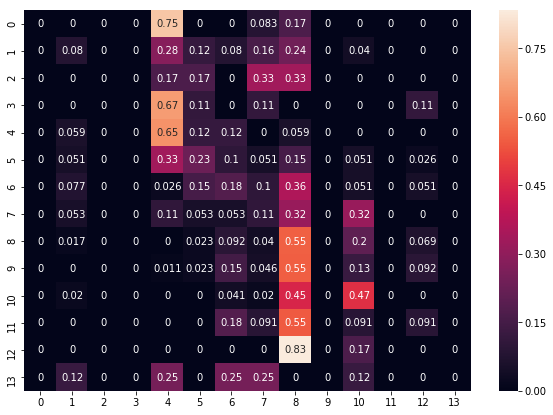

In [149]:
cm=confusion_matrix(Y_test,pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,7))
sns.heatmap(cm,annot=True)

In [150]:
print(classification_report(Y_test,pred))

                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        12
          Appeal_to_fear-prejudice       0.14      0.08      0.10        25
    Bandwagon,Reductio_ad_hitlerum       0.00      0.00      0.00         6
           Black-and-White_Fallacy       0.00      0.00      0.00         9
         Causal_Oversimplification       0.21      0.65      0.31        17
                             Doubt       0.31      0.23      0.26        39
         Exaggeration,Minimisation       0.14      0.18      0.16        39
                       Flag-Waving       0.06      0.11      0.08        19
                   Loaded_Language       0.45      0.55      0.50       173
             Name_Calling,Labeling       0.00      0.00      0.00        87
                        Repetition       0.28      0.47      0.35        49
                           Slogans       0.00      0.00      0.00        11
       Thou

/home/somesh/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# writing predictions to file
with open(task_TC_output_file, "w") as fout:
    for article_id, prediction, span_start, span_end in zip(dev_article_ids, predictions, dev_span_starts, dev_span_ends):
        fout.write("%s\t%s\t%s\t%s\n" % (article_id, prediction, span_start, span_end))
print("Predictions written to file " + task_TC_output_file)

In [9]:
def clean(text):
    text=text.lower()
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text=re.sub('[“"”]',' " ',text)
    retain='[^abcdefghijklmnopqrstuvwxyz!#?" ]'
    text=re.sub('[()–-]',' ',text)
    text=re.sub(retain,'',text)
    text=text.replace('?',' ? ')
    text=text.replace('#',' # ')
    text=text.replace('!',' ! ')
    return ' '.join(text.split())

in_data=[(id, [int(sps),int(spe)], l)for id, sps, spe, l in zip(ref_articles_id, ref_span_starts, ref_span_ends, train_gold_labels)]
df=pd.DataFrame(in_data,columns=['ID','Span','Label'])
df['Sentence']=[read_span(id,span) for id,span in zip(df['ID'].tolist(),df['Span'].tolist())]
#df['Sentence']=df['Sentence'].apply(lambda x : clean(x))
df['Target']=train_gold_labels

In [157]:
df['Span']=df['Span'].apply(lambda x : x[1]-x[0])
df=df.drop_duplicates()

In [23]:
for i in len(df):
    for j in len(df):
        if df[]

The next transmission could be more pronounced or stronger
when (the plague) comes again it starts from more stock, and the magnitude in the next transmission could be higher than the one that we saw
appeared
a very, very different
He also pointed to the presence of the pneumonic version, which spreads more easily and is more virulent, in the latest outbreak
but warned that the danger was not over
the magnitude in the next transmission could be higher
it could even spill over into neighbouring countries and beyond
Stop Islamization of America
We condemn all those whose behaviours and views run counter to our shared values
Defeat Jihad"
the nation that gave the world the Magna Carta is dead"
The UK should never become a stage for inflammatory speakers who promote hate."
hate preachers
delighted" with the decision
a striking blow against freedom
so-called land of democracy and freedom of speech
hair trigger in single-action mode
sanctuary" policy
politicians across this country continue 

consistent
consistent
And just what kind of policies are we talking about?
law-abiding citizens
law-abiding citizens
our
our
our
extremely careless
Jim Comey and Jim Comey alone
Jim Comey and Jim Comey alone
devastating
gross negligence
deep state plot
negligence
the victim of a scurrilous slander campaign
the systematic brutality, the widespread atrocities, the ruthless suppression of independent thought
Long live the Fifth Estate
after the Vichy government that served ad enabled the German occupation of France
ossified bureaucracies incapable of acting quickly and decisively
Fourth Estate on Life Support
Fourth Estate now on life support
Small wonder
a show trial
generated worldwide condemnation
a Church
unseemly sycophancy
cooped up
putting extraordinary pressure
All for spreading unwelcome truth around
get their hands on him
unseemly sycophancy
the noble profession of journalism
deafening
Vichy journalists
No investigative journalism in my lifetime can equal the importance of what 

### TOPIC MODELLING

In [5]:
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux
def compute_feature(sentence):
    feat=[]
    for prop in Propagandas:
        val=0
        for tok in sentence.split():
            if tok in tfilf[prop]:
                val=val+tfilf[prop][tok]
        feat.append(val)     
    return feat

In [128]:
Propagandas=set(df['Label'])
Topic_freq=dict()
for prop in Propagandas:
    wl=(' '.join(df[df['Label']==prop]['Sentence'].tolist())).split(' ')
    Topic_freq[prop]=wordListToFreqDict(wl)

In [129]:
wl=(' '.join(df['Sentence'].tolist())).split(' ')
freq=wordListToFreqDict(wl)

In [160]:
tfilf=dict()
L=len(df)
for prop in Topic_freq:
    tfilf[prop]=dict()
    l=len(df[df['Label']==prop])
    for word in Topic_freq[prop]:
        if freq[word]>85:
            num=Topic_freq[prop][word]/l
            den=(freq[word]-Topic_freq[prop][word])/(L-l)
            if num/den > 1 :
                tfilf[prop][word]=num/den

In [218]:
Data=pd.DataFrame([compute_feature(sentence) for sentence in df['Sentence'].tolist()])
Data=Data.join(df).drop(['Sentence','Label'],axis=1)
Data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,ID,Span,Target
0,0.0,6.952200,3.115582,20.563278,0.000000,0.0,0.000000,12.094343,3.651963,14.935163,12.200651,4.250692,11.706682,11.012212,111111111,58.0,Appeal_to_Authority
1,0.0,22.830272,10.511920,33.058027,0.000000,0.0,1.661365,28.730193,6.956577,43.271680,38.626060,19.322644,38.065893,39.265640,111111111,140.0,Appeal_to_Authority
2,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,111111111,8.0,Doubt
3,0.0,1.778481,0.000000,2.973786,1.018436,0.0,0.000000,1.865517,0.000000,2.825531,2.237846,0.000000,1.762413,2.237249,111111111,22.0,Repetition
4,0.0,23.150569,11.003055,20.891769,0.000000,0.0,1.168210,28.291816,5.443280,37.272721,33.981486,14.537062,27.037058,33.597129,111111111,128.0,Appeal_to_fear-prejudice


In [219]:
Data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Span
count,6009.000000,6009.000000,6009.000000,6009.000000,6009.000000,6009.000000,6009.000000,6009.000000,6009.000000,6009.000000,6009.000000,6009.000000,6009.000000,6009.000000,5664.000000
mean,0.173337,6.931597,1.704583,9.001441,0.380342,0.019473,0.862369,6.988765,1.669760,10.267301,10.538848,5.250839,7.953853,11.125497,48.687147
std,0.567568,10.842084,2.881059,14.285210,0.904201,0.143862,1.788524,10.752415,3.285135,15.860159,16.516984,9.033308,12.408282,17.669252,59.517632
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000
50%,0.000000,2.234572,0.000000,2.973786,0.000000,0.000000,0.000000,2.537211,0.000000,4.066255,3.716378,1.540995,2.706653,3.694472,26.000000
75%,0.000000,9.030281,2.139243,11.574588,0.000000,0.000000,1.168210,9.058337,1.723547,13.214079,13.423888,6.214766,10.231914,14.071106,56.000000
max,7.248688,122.161330,31.533549,181.828744,14.304166,2.089564,22.708101,127.402886,34.548575,212.817756,214.073782,123.749638,158.114552,197.203932,712.000000


In [225]:
Data.dropna(inplace=True)
Data.drop([0,4,5],axis=1,inplace=True)
X_train, X_test, Y_train, Y_test = train_test_split(Data.drop(['Target','ID'],axis=1), Data['Target'], test_size=500, stratify=Data['Target'], random_state=1234)

## XGB GRID

In [203]:
### A parameter grid for XGBoost
params = {
        'min_child_weight': [2, 3],
        'gamma': [1.5,1.25],
        'subsample': [0.95, 1.0],
        'colsample_bytree': [0.95, 1.0],
        'max_depth': [11, 12,13],
        'num_classes' : [14]
        }
xgb = XGBClassifier(learning_rate=0.01, n_estimators=1024, objective='multi:softmax',
                    silent=True, nthread=1)

In [259]:
%%time
folds = 3
param_comb = 4
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(X_train, Y_train), verbose=0, random_state=1001 )
random_search.fit(X_train, Y_train)

CPU times: user 1min 51s, sys: 271 ms, total: 1min 51s
Wall time: 7min 57s


In [260]:
print('\n Best estimator:')
print(random_search.best_estimator_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, gamma=1.5, learning_rate=0.01,
       max_delta_step=0, max_depth=13, min_child_weight=3, missing=None,
       n_estimators=1024, n_jobs=1, nthread=1, num_classes=14,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0)


In [261]:
MODEL='XGB'
if MODEL=='XGB' :
    model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, gamma=1.5, learning_rate=0.01,
       max_delta_step=0, max_depth=13, min_child_weight=3, missing=None,
       n_estimators=1024, n_jobs=1, nthread=1, num_classes=14,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0)
    model.fit(X_train, Y_train, eval_metric='merror')
else:
    model = LogisticRegression(penalty='l2', class_weight='balanced')
    model.fit(X_train, Y_train)

In [262]:
pred_m = model.predict(X_test)

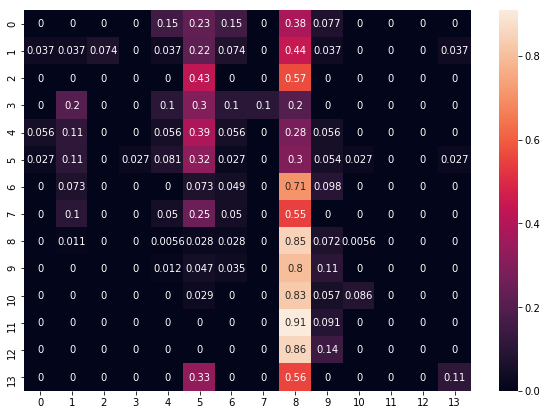

In [263]:
cm=confusion_matrix(Y_test,pred_m)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,7))
sns.heatmap(cm,annot=True)

In [264]:
print(classification_report(Y_test,pred_m))

                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        13
          Appeal_to_fear-prejudice       0.06      0.04      0.05        27
    Bandwagon,Reductio_ad_hitlerum       0.00      0.00      0.00         7
           Black-and-White_Fallacy       0.00      0.00      0.00        10
         Causal_Oversimplification       0.09      0.06      0.07        18
                             Doubt       0.22      0.32      0.26        37
         Exaggeration,Minimisation       0.11      0.05      0.07        41
                       Flag-Waving       0.00      0.00      0.00        20
                   Loaded_Language       0.44      0.85      0.58       180
             Name_Calling,Labeling       0.26      0.11      0.15        85
                        Repetition       0.60      0.09      0.15        35
                           Slogans       0.00      0.00      0.00        11
       Thou

/home/somesh/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
